In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
# import os
# import pandas as pd

2023-06-10 20:07:51.527959: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/dataset_4/training"
val_path = "/drive0-storage/Gracia/dataset_4/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-10 20:07:53.609797: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 20:07:54.186287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 30732 files belonging to 3 classes.
Found 7680 files belonging to 3 classes.


In [4]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 249.0
(184, 216, 3)


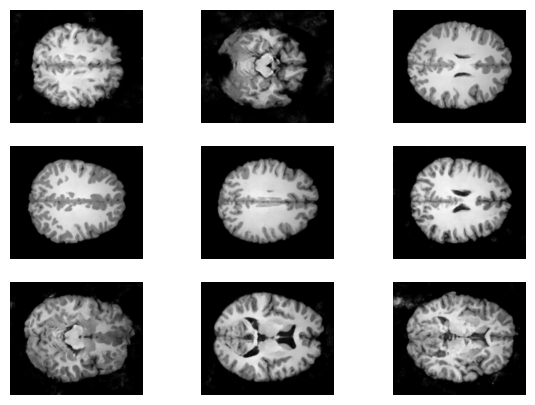

In [8]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [6]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [7]:
print(len(validation_dataset))
print(len(test_dataset))

120
120


## Model building

In [8]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [9]:
with tf.device("GPU"):
    vgg16 = build_vgg16()

    # add rescale layer, chain model
    rescale = tf.keras.layers.Rescaling(1./255)
    inputs = tf.keras.Input(shape = img_shape)
    x = rescale(inputs)
    outputs = vgg16(x)
    model = tf.keras.Model(inputs,outputs) 
    
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [10]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn4_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [11]:
EPOCH = 25

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/25


2023-06-10 20:08:06.376648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-10 20:08:07.638249: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


961/961 [==============================] - 163s 165ms/step - loss: 0.7741 - accuracy: 0.6622 - val_loss: 1.4441 - val_accuracy: 0.3372
Epoch 2/25
961/961 [==============================] - 158s 164ms/step - loss: 0.5346 - accuracy: 0.7985 - val_loss: 1.2777 - val_accuracy: 0.3961
Epoch 3/25
961/961 [==============================] - 158s 164ms/step - loss: 0.4658 - accuracy: 0.8223 - val_loss: 1.3217 - val_accuracy: 0.3786
Epoch 4/25
961/961 [==============================] - 157s 164ms/step - loss: 0.4295 - accuracy: 0.8338 - val_loss: 1.2857 - val_accuracy: 0.3807
Epoch 5/25
961/961 [==============================] - 157s 164ms/step - loss: 0.4027 - accuracy: 0.8423 - val_loss: 1.2272 - val_accuracy: 0.4026
Epoch 6/25
961/961 [==============================] - 158s 164ms/step - loss: 0.3785 - accuracy: 0.8520 - val_loss: 1.2910 - val_accuracy: 0.4005
Epoch 7/25
961/961 [==============================] - 157s 164ms/step - loss: 0.3600 - accuracy: 0.8573 - val_loss: 1.1438 - val_accura

In [13]:
model.save('./models/cnn4_25epoch.h5')

In [14]:
acc

[0.6622413396835327,
 0.7984511256217957,
 0.8223024606704712,
 0.8338214159011841,
 0.842346727848053,
 0.8520434498786926,
 0.8573473691940308,
 0.8658726811408997,
 0.8737472295761108,
 0.8808733820915222,
 0.8929454684257507,
 0.9067746996879578,
 0.9184888601303101,
 0.9344006180763245,
 0.9476767182350159,
 0.9583821296691895,
 0.9670376181602478,
 0.9737406969070435,
 0.979174792766571,
 0.9848366379737854,
 0.9834049344062805,
 0.9843810796737671,
 0.9888715147972107,
 0.9898151755332947,
 0.9914095997810364]

In [15]:
val_acc

[0.3372395932674408,
 0.3960937559604645,
 0.3786458373069763,
 0.38072916865348816,
 0.4026041626930237,
 0.40052083134651184,
 0.4203124940395355,
 0.4781250059604645,
 0.4986979067325592,
 0.4984374940395355,
 0.5466145873069763,
 0.5606771111488342,
 0.6557291746139526,
 0.6770833134651184,
 0.65234375,
 0.7598958611488342,
 0.7473958134651184,
 0.7229166626930237,
 0.8059895634651184,
 0.7669270634651184,
 0.7955729365348816,
 0.7580729126930237,
 0.8080729246139526,
 0.8307291865348816,
 0.7966145873069763]

In [16]:
loss

[0.7741458415985107,
 0.534604012966156,
 0.4658164083957672,
 0.42947277426719666,
 0.40271562337875366,
 0.3784528374671936,
 0.36002472043037415,
 0.3358324468135834,
 0.315120667219162,
 0.2950436770915985,
 0.2657697796821594,
 0.23202531039714813,
 0.2071971446275711,
 0.16831961274147034,
 0.13788530230522156,
 0.10908854007720947,
 0.09091045707464218,
 0.07337886840105057,
 0.06007138639688492,
 0.04393903538584709,
 0.047592729330062866,
 0.043779078871011734,
 0.03340546786785126,
 0.03024369850754738,
 0.026219747960567474]

In [17]:
val_loss

[1.4440981149673462,
 1.277707576751709,
 1.321702480316162,
 1.285665512084961,
 1.2272306680679321,
 1.2909659147262573,
 1.14380943775177,
 1.090617299079895,
 1.0383789539337158,
 1.1491366624832153,
 0.9997945427894592,
 1.0215319395065308,
 0.8063918948173523,
 0.7694067358970642,
 0.9745534658432007,
 0.6569079756736755,
 0.8018261790275574,
 0.9030255079269409,
 0.5934422016143799,
 0.9198716282844543,
 0.7871750593185425,
 0.8980432748794556,
 0.6812700629234314,
 0.5614868402481079,
 0.7477760910987854]

### Training evaluation

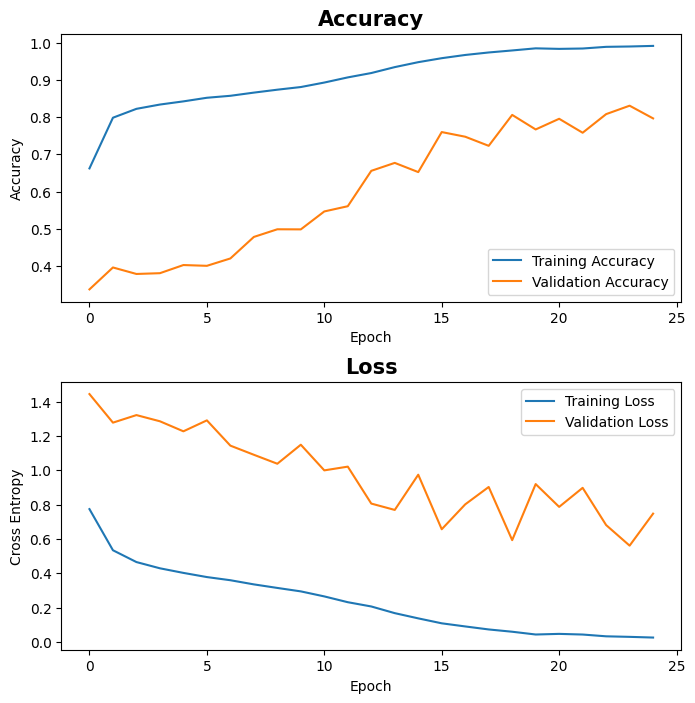

In [18]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

## Testing

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [20]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

120/120 [==============================] - 7s 56ms/step - loss: 0.7762 - accuracy: 0.7891


{'loss': 0.7761930823326111, 'accuracy': 0.7890625}

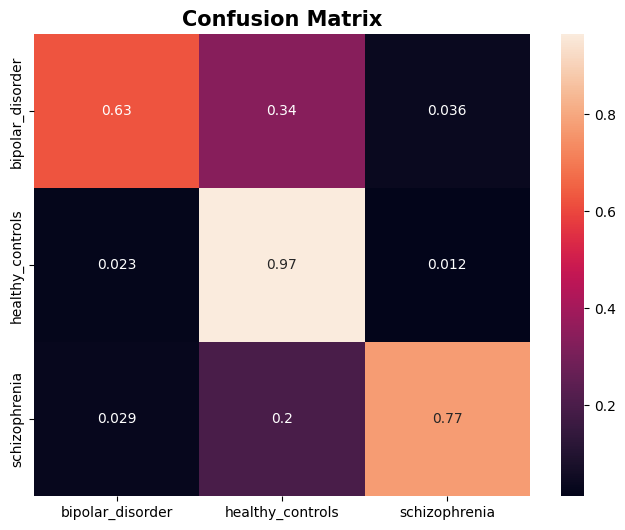

In [21]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN4_cm.png')
plt.show()

In [22]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.7890625
Precision: 0.8361704825950755
Sensitivity: 0.7875
Specificity: 0.8940987193185791
